In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
import ignite
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
import string
pd.set_option("display.max_columns", 101)
pd.set_option("display.max_rows", 101)
np.random.seed(123)
torch.manual_seed(123)
#https://www.analyticsvidhya.com/blog/2019/01/guide-pytorch-neural-networks-case-studies/

In [2]:
df = pd.read_csv('PBP - 2016 - Week 1.csv')
df.head()

,gameId,year,week,homeId,homeTeam,homeAbbr,awayId,awayTeam,awayAbbr,driveIndex,playIndex,offenseId,offenseTeam,offenseAbbr,defenseId,defenseTeam,defenseAbbr,homeScore,awayScore,quarter,clock,wallclock,type,down,distance,yardLine,yardsGained,endYardLine,description
0,400868876,2016,1,239,Baylor,BAY,2466,Northwestern St,NWST,0,0,239,Baylor,BAY,2466,Northwestern St,NWST,0,0,1,15:00,2016-09-03T06:36:41Z,Kickoff,1,10,35,10,86,"Drew Galitz kickoff for 61 yds , Shakeir Ryan ..."
1,400868876,2016,1,239,Baylor,BAY,2466,Northwestern St,NWST,0,1,2466,Northwestern St,NWST,239,Baylor,BAY,0,0,1,14:55,2016-09-03T06:38:11Z,Timeout,1,10,86,0,86,"Timeout NORTHWESTERN ST, clock 14:55"
2,400868876,2016,1,239,Baylor,BAY,2466,Northwestern St,NWST,0,2,2466,Northwestern St,NWST,239,Baylor,BAY,0,0,1,14:55,2016-09-03T06:38:11Z,Rush,1,10,86,-1,87,De'Mard Llorens run for a loss of 1 yard to th...
3,400868876,2016,1,239,Baylor,BAY,2466,Northwestern St,NWST,0,3,2466,Northwestern St,NWST,239,Baylor,BAY,0,0,1,14:55,2016-09-03T06:38:11Z,Rush,2,11,87,8,79,De'Mard Llorens run for 8 yds to the NWSt 21
4,400868876,2016,1,239,Baylor,BAY,2466,Northwestern St,NWST,0,4,2466,Northwestern St,NWST,239,Baylor,BAY,0,0,1,14:55,2016-09-03T06:38:11Z,Rush,3,3,79,0,79,De'Mard Llorens run for no gain to the NWSt 21


In [27]:
df.query('driveIndex == 1 & gameId == 400868876').iloc[[-1]]['type'].values[0]

'Rushing Touchdown'

### Make the Result Column

In [25]:
def getDriveResult(driveId, gameId, df):
    final = df.query('driveIndex == @driveId & gameId == @gameId').iloc[[-1]]
    return final['type'].values[0]

In [31]:
for index,row in df.iterrows():
    df.at[index,'result'] = getDriveResult(row['driveIndex'], row['gameId'], df)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109


3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770


5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418


6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090


8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
8741
8742
8743
8744
8745
8746
8747
8748
8749
8750
8751
8752
8753
8754
8755
8756
8757
8758
8759
8760
8761
8762
8763
8764
8765
8766
8767
8768
8769
8770
8771
8772
8773
8774
8775
8776
8777
8778
8779
8780
8781
8782
8783
8784
8785


10266
10267
10268
10269
10270
10271
10272
10273
10274
10275
10276
10277
10278
10279
10280
10281
10282
10283
10284
10285
10286
10287
10288
10289
10290
10291
10292
10293
10294
10295
10296
10297
10298
10299
10300
10301
10302
10303
10304
10305
10306
10307
10308
10309
10310
10311
10312
10313
10314
10315
10316
10317
10318
10319
10320
10321
10322
10323
10324
10325
10326
10327
10328
10329
10330
10331
10332
10333
10334
10335
10336
10337
10338
10339
10340
10341
10342
10343
10344
10345
10346
10347
10348
10349
10350
10351
10352
10353
10354
10355
10356
10357
10358
10359
10360
10361
10362
10363
10364
10365
10366
10367
10368
10369
10370
10371
10372
10373
10374
10375
10376
10377
10378
10379
10380
10381
10382
10383
10384
10385
10386
10387
10388
10389
10390
10391
10392
10393
10394
10395
10396
10397
10398
10399
10400
10401
10402
10403
10404
10405
10406
10407
10408
10409
10410
10411
10412
10413
10414
10415
10416
10417
10418
10419
10420
10421
10422
10423
10424
10425
10426
10427
10428
10429
10430
10431
1043

11639
11640
11641
11642
11643
11644
11645
11646
11647
11648
11649
11650
11651
11652
11653
11654
11655
11656
11657
11658
11659
11660
11661
11662
11663
11664
11665
11666
11667
11668
11669
11670
11671
11672
11673
11674
11675
11676
11677
11678
11679
11680
11681
11682
11683
11684
11685
11686
11687
11688
11689
11690
11691
11692
11693
11694
11695
11696
11697
11698
11699
11700
11701
11702
11703
11704
11705
11706
11707
11708
11709
11710
11711
11712
11713
11714
11715
11716
11717
11718
11719
11720
11721
11722
11723
11724
11725
11726
11727
11728
11729
11730
11731
11732
11733
11734
11735
11736
11737
11738
11739
11740
11741
11742
11743
11744
11745
11746
11747
11748
11749
11750
11751
11752
11753
11754
11755
11756
11757
11758
11759
11760
11761
11762
11763
11764
11765
11766
11767
11768
11769
11770
11771
11772
11773
11774
11775
11776
11777
11778
11779
11780
11781
11782
11783
11784
11785
11786
11787
11788
11789
11790
11791
11792
11793
11794
11795
11796
11797
11798
11799
11800
11801
11802
11803
11804
1180

13047
13048
13049
13050
13051
13052
13053
13054
13055
13056
13057
13058
13059
13060
13061
13062
13063
13064
13065
13066
13067
13068
13069
13070
13071
13072
13073
13074
13075
13076
13077
13078
13079
13080
13081
13082
13083
13084
13085
13086
13087
13088
13089
13090
13091
13092
13093
13094
13095
13096
13097
13098
13099
13100
13101
13102
13103
13104
13105
13106
13107
13108
13109
13110
13111
13112
13113
13114
13115
13116
13117
13118
13119
13120
13121
13122
13123
13124
13125
13126
13127
13128
13129
13130
13131
13132
13133
13134
13135
13136
13137
13138
13139
13140
13141
13142
13143
13144
13145
13146
13147
13148
13149
13150
13151
13152
13153
13154
13155
13156
13157
13158
13159
13160
13161
13162
13163
13164
13165
13166
13167
13168
13169
13170
13171
13172
13173
13174
13175
13176
13177
13178
13179
13180
13181
13182
13183
13184
13185
13186
13187
13188
13189
13190
13191
13192
13193
13194
13195
13196
13197
13198
13199
13200
13201
13202
13203
13204
13205
13206
13207
13208
13209
13210
13211
13212
1321

14493
14494
14495
14496
14497
14498
14499
14500
14501
14502
14503
14504
14505
14506
14507
14508
14509
14510
14511
14512
14513
14514
14515
14516
14517
14518
14519
14520
14521
14522
14523
14524
14525
14526
14527
14528
14529
14530
14531
14532
14533
14534
14535
14536
14537
14538
14539
14540
14541
14542
14543
14544
14545
14546
14547
14548
14549
14550
14551
14552
14553
14554
14555
14556
14557
14558
14559
14560
14561
14562
14563
14564
14565
14566
14567
14568
14569
14570
14571
14572
14573
14574
14575
14576
14577
14578
14579
14580
14581
14582
14583
14584
14585
14586
14587
14588
14589
14590
14591
14592
14593
14594
14595
14596
14597
14598
14599
14600
14601
14602
14603
14604
14605
14606
14607
14608
14609
14610
14611
14612
14613
14614
14615
14616
14617
14618
14619
14620
14621
14622
14623
14624
14625
14626
14627
14628
14629
14630
14631
14632
14633
14634
14635
14636
14637
14638
14639
14640
14641
14642
14643
14644
14645
14646
14647
14648
14649
14650
14651
14652
14653
14654
14655
14656
14657
14658
1465

15921
15922
15923
15924
15925
15926
15927
15928
15929
15930
15931
15932
15933
15934
15935
15936
15937
15938
15939
15940
15941
15942
15943
15944
15945
15946
15947
15948
15949
15950
15951
15952
15953
15954
15955
15956
15957
15958
15959
15960
15961
15962
15963
15964
15965
15966
15967
15968
15969
15970
15971
15972
15973
15974
15975
15976
15977
15978
15979
15980
15981
15982
15983
15984
15985
15986
15987
15988
15989
15990
15991
15992
15993
15994
15995
15996
15997
15998
15999
16000
16001
16002
16003
16004
16005
16006
16007
16008
16009
16010
16011
16012
16013
16014
16015
16016
16017
16018
16019
16020
16021
16022
16023
16024
16025
16026
16027
16028
16029
16030
16031
16032
16033
16034
16035
16036
16037
16038
16039
16040
16041
16042
16043
16044
16045
16046
16047
16048
16049
16050
16051
16052
16053
16054
16055
16056
16057
16058
16059
16060
16061
16062
16063
16064
16065
16066
16067
16068
16069
16070
16071
16072
16073
16074
16075
16076
16077
16078
16079
16080
16081
16082
16083
16084
16085
16086
1608

In [438]:
df.query('result == "Fumble Return Touchdown"').size

300

In [60]:
df['description'] = df['description'].str.replace('[^\w\s]','')
df['description'] = df['description'].str.replace('[{}]'.format(string.punctuation), '')
df['result'] = df['result'].str.replace('[^\w\s]','')

In [146]:
x_train = df['description']
y_train = df['result']

x_train = x_train.values
y_train = y_train.values

### Tokenization

In [147]:
## create tokens 
tokenizer = keras.preprocessing.text.Tokenizer(num_words = 1000)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

In [148]:
## ensure that all the data is actually text
new_x_train = []
for i in x_train:
    new_x_train.append(str(i))
    
x_train = new_x_train

In [149]:
## ensure that all the data is actually text
new_y_train = []
for i in y_train:
    new_y_train.append(str(i))
    
y_train = new_y_train

In [150]:
## convert texts to padded sequences 
x_train = tokenizer.texts_to_sequences(x_train)
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen = 70)

In [56]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

# Function takes a tokenized sentence and returns the words
def sequence_to_text(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)

In [67]:
EMBEDDING_FILE = 'glove.840B.300d.txt'

embeddings_index = {}
for i, line in enumerate(open(EMBEDDING_FILE, encoding='utf8')):
    val = line.split()
    embeddings_index[val[0]] = np.asarray(val[1:], dtype='float32')
    


ValueError: could not convert string to float: '.'

In [70]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [309]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        ## Embedding Layer, Add parameter 
        self.embedding = nn.Embedding(2000, embedding_matrix.size) 
        et = torch.tensor(embedding_matrix, dtype=torch.float32)
        self.embedding.weight = nn.Parameter(et)
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = nn.Dropout2d(0.1)
        self.lstm = nn.LSTM(300, 40)        
        self.linear = nn.Linear(40, df['result'].unique().size)
        self.out = nn.Linear(df['result'].unique().size, df['result'].unique().size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h_embedding = self.embedding(x)        
        h_lstm, _ = self.lstm(h_embedding)
        max_pool, _ = torch.max(h_lstm, 1)        
        linear = self.relu(self.linear(max_pool))
        out = self.out(linear)
        return out
    
model = Model()

In [153]:
## create training and validation split 
split_size = int(0.8 * len(df))
index_list = list(range(len(df)))
train_idx, valid_idx = index_list[:split_size], index_list[split_size:]

In [163]:
y_tr_prep = []
for i in train_idx:
    y_tr_prep.append(y_train[i])

In [171]:
for i in df['result'].unique():
    print(i)

Punt
Rushing Touchdown
Field Goal Good
Passing Touchdown
Pass Incompletion
End of Half
Fumble Recovery Opponent
End of Game
Field Goal Missed
Penalty
Pass Interception Return
Blocked Field Goal
Defensive 2pt Conversion
Rush
End Period
Pass Reception
Timeout
Sack
Interception Return Touchdown
Fumble Recovery Own
Kickoff
Kickoff Return Touchdown
Safety
Blocked Punt
Punt Return Touchdown
nan
Fumble Return Touchdown


In [184]:
y_tr_prep = []
for result in y_train:
    i = 0
    for type in df['result'].unique():
        if(result == type):
            y_tr_prep.append(i)
        i+=1
            
            
new_prep = []
for i in train_idx:
    new_prep.append(y_tr_prep[i])
y_tr_prep = new_prep



In [341]:
y_valid_prep = []
for index,row in df.iterrows():
    i = 0
    for type in df['result'].unique():
        if(result == type):
            y_valid_prep.append(i)
        i+=1

print(len(new_prep))


new_prep = []
for i in valid_idx:
    new_prep.append(y_valid_prep[i])
    
y_valid_prep = new_prep

3224


In [337]:
len(y_train)

16141

In [340]:
y_valid_prep = []
for result in y_train:
    i = 0
    for type in df['result'].unique():
        if(result == type):
            y_valid_prep.append(i)
        i+=1

new_prep = []
for i in valid_idx:
    new_prep.append(y_valid_prep[i])
y_valid_prep = new_prep

IndexError: list index out of range

In [335]:
print(len(y_valid_prep))
len(valid_idx)

3223


3229

In [342]:
## create iterator objects for train and valid datasets
x_tr = torch.tensor(x_train[train_idx], dtype=torch.long)
y_tr = torch.tensor(y_tr_prep, dtype=torch.float32)
train = TensorDataset(x_tr, y_tr)

## Just trying to get a good weight
test = torch.tensor(y_tr_prep, dtype=torch.int)
print(test)
class_sample_count = np.unique(test, return_counts=True)[1]
print(class_sample_count)
weight = 1. / class_sample_count

print(weight)
samples_weight = weight[test]
print(len(samples_weight))



trainloader = torch.utils.data.DataLoader(train, batch_size=1,sampler=torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight)))

x_val = torch.tensor(x_train[valid_idx], dtype=torch.long)
y_val = torch.tensor(y_valid_prep, dtype=torch.float32)
valid = TensorDataset(x_val, y_val)
validloader = torch.utils.data.DataLoader(valid, batch_size=1)





tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.int32)
[4618 1699 1467 1650  306  393  348  380  564   67  503   79   10  295
   99   77   25  176   68   24    6    3   31   18    6]
[2.16543958e-04 5.88581519e-04 6.81663258e-04 6.06060606e-04
 3.26797386e-03 2.54452926e-03 2.87356322e-03 2.63157895e-03
 1.77304965e-03 1.49253731e-02 1.98807157e-03 1.26582278e-02
 1.00000000e-01 3.38983051e-03 1.01010101e-02 1.29870130e-02
 4.00000000e-02 5.68181818e-03 1.47058824e-02 4.16666667e-02
 1.66666667e-01 3.33333333e-01 3.22580645e-02 5.55555556e-02
 1.66666667e-01]
12912


In [310]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

In [365]:
for epoch in range(30):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_function(outputs, labels.long())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

[1,  2000] loss: 1.334
[1,  4000] loss: 1.354
[1,  6000] loss: 1.365
[1,  8000] loss: 1.344
[1, 10000] loss: 1.320
[1, 12000] loss: 1.330
[2,  2000] loss: 1.365
[2,  4000] loss: 1.336
[2,  6000] loss: 1.386
[2,  8000] loss: 1.390
[2, 10000] loss: 1.334
[2, 12000] loss: 1.366
[3,  2000] loss: 1.412
[3,  4000] loss: 1.389
[3,  6000] loss: 1.380
[3,  8000] loss: 1.342
[3, 10000] loss: 1.331
[3, 12000] loss: 1.368
[4,  2000] loss: 1.420
[4,  4000] loss: 1.402
[4,  6000] loss: 1.372
[4,  8000] loss: 1.367
[4, 10000] loss: 1.308
[4, 12000] loss: 1.366
[5,  2000] loss: 1.390
[5,  4000] loss: 1.437
[5,  6000] loss: 1.393
[5,  8000] loss: 1.442
[5, 10000] loss: 1.360
[5, 12000] loss: 1.406
[6,  2000] loss: 1.410
[6,  4000] loss: 1.390
[6,  6000] loss: 1.376
[6,  8000] loss: 1.388
[6, 10000] loss: 1.400
[6, 12000] loss: 1.412
[7,  2000] loss: 1.385
[7,  4000] loss: 1.392
[7,  6000] loss: 1.393
[7,  8000] loss: 1.356
[7, 10000] loss: 1.374
[7, 12000] loss: 1.407
[8,  2000] loss: 1.438
[8,  4000] 

In [247]:
softmax = nn.Softmax()

In [393]:
total_correct = 0
total_images = 0
preds = np.empty((0,1))
lebs = np.empty((0,1))
confusion_matrix = np.zeros([27,27], int)
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels.long()).sum().item()
        preds = np.append(preds,predicted)
        lebs = np.append(lebs,labels)
        for i, l in enumerate(labels):
            confusion_matrix[int(l.item()), predicted[i].item()] += 1 

print(total_correct)
model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} train plays: {1:.2f}%'.format(total_images, model_accuracy))

6747
Model accuracy on 12912 train plays: 52.25%


In [368]:
# model_directory_path = './models/'
# model_path = model_directory_path + 'drive-predictor-mlp-1.pt'
# torch.save(model.state_dict(), model_path)

In [272]:
softmax(model(x_tr[23].unsqueeze(0)))

/usr/local/Cellar/ipython/7.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[3.3676e-01, 1.3001e-01, 1.1210e-01, 1.4262e-01, 2.3763e-02, 3.1304e-02,
         2.7400e-02, 3.1378e-02, 4.6385e-02, 5.2695e-03, 4.0285e-02, 6.2177e-03,
         7.8843e-04, 2.3580e-02, 7.7809e-03, 6.0888e-03, 1.9740e-03, 1.3885e-02,
         5.3413e-03, 1.8886e-03, 4.9410e-04, 2.9903e-04, 2.4516e-03, 1.4195e-03,
         4.9395e-04, 1.4249e-05, 1.4249e-05]], grad_fn=<SoftmaxBackward>)

In [321]:
for j in range(len(x_tr)):
    probs, index = torch.max(softmax(model(x_tr[j].unsqueeze(0))), dim=1)
    for p, i in zip(probs, index):
        print('{0} - {1:.4f}'.format(df['result'].unique()[i], p))

/usr/local/Cellar/ipython/7.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


Blocked Field Goal - 0.4523
End of Game - 0.6403
Punt - 0.2076
Pass Incompletion - 0.1017
End of Half - 0.1654
Rushing Touchdown - 0.1698
Sack - 0.1747
Pass Incompletion - 0.1161
Sack - 0.8087
Pass Incompletion - 0.1417
Field Goal Good - 0.1509
Field Goal Missed - 0.1325
Pass Reception - 0.1834
Pass Reception - 0.2695
Field Goal Good - 0.1944
Field Goal Missed - 0.3341
Pass Incompletion - 0.2439
Field Goal Missed - 0.4502
Sack - 0.1456
Pass Incompletion - 0.1410
Penalty - 0.1743
Fumble Recovery Opponent - 0.2866
Penalty - 0.2128
Pass Reception - 0.2700
Field Goal Good - 0.1886
End Period - 0.1579
Pass Reception - 0.2695
Sack - 0.3468
Field Goal Missed - 0.1277
Sack - 0.3468
Sack - 0.2257
Pass Incompletion - 0.3224
Penalty - 0.2958
Field Goal Good - 0.1690
Field Goal Missed - 0.1797
Sack - 0.3434
Sack - 0.3372
Timeout - 0.1265
End of Half - 0.1362
Pass Reception - 0.2695
Rushing Touchdown - 0.3915
Fumble Recovery Opponent - 0.2197
Sack - 0.2028
Sack - 0.2028
End of Half - 0.1103
Pass In

Penalty - 0.2147
Rushing Touchdown - 0.5102
Rushing Touchdown - 0.2589
Kickoff Return Touchdown - 0.3462
Field Goal Missed - 0.1797
Pass Incompletion - 0.1581
Field Goal Missed - 0.1575
Field Goal Missed - 0.1166
Passing Touchdown - 0.2281
Rushing Touchdown - 0.3411
Rushing Touchdown - 0.2579
Rushing Touchdown - 0.2501
Rushing Touchdown - 0.2078
Rushing Touchdown - 0.2747
Field Goal Missed - 0.2766
Pass Interception Return - 0.4070
Field Goal Missed - 0.1656
Pass Interception Return - 0.5711
Rushing Touchdown - 0.2727
Field Goal Missed - 0.2110
Pass Interception Return - 0.2303
Passing Touchdown - 0.3435
Interception Return Touchdown - 0.5270
Rushing Touchdown - 0.2116
Fumble Recovery Opponent - 0.2927
Field Goal Missed - 0.1368
Pass Incompletion - 0.1827
End of Game - 0.6961
Field Goal Good - 0.1046
Fumble Recovery Own - 0.7807
Passing Touchdown - 0.1970
Pass Interception Return - 0.2173
Interception Return Touchdown - 0.5270
Rushing Touchdown - 0.2297
Pass Reception - 0.3123
Field Go

Passing Touchdown - 0.2095
Field Goal Missed - 0.4638
Interception Return Touchdown - 0.5713
Pass Reception - 0.5781
Penalty - 0.9169
Sack - 0.2289
Pass Reception - 0.3291
Rushing Touchdown - 0.1946
Passing Touchdown - 0.1857
Passing Touchdown - 0.2006
Passing Touchdown - 0.2887
Timeout - 0.1265
Passing Touchdown - 0.2670
Passing Touchdown - 0.2211
Field Goal Missed - 0.2553
Field Goal Missed - 0.2827
Passing Touchdown - 0.1871
Pass Incompletion - 0.2063
Field Goal Good - 0.2477
Fumble Recovery Own - 0.6463
End of Game - 0.3634
End of Half - 0.5808
Fumble Recovery Own - 0.6463
Pass Interception Return - 0.2029
Pass Reception - 0.7728
Pass Reception - 0.9893
Pass Reception - 0.7875
Pass Reception - 0.8141
Pass Reception - 0.5778
Pass Reception - 0.6187
Pass Reception - 0.7093
Pass Reception - 0.4255
Passing Touchdown - 0.1260
Pass Incompletion - 0.2675
Passing Touchdown - 0.2912
Rushing Touchdown - 0.2428
Passing Touchdown - 0.1701
Passing Touchdown - 0.1712
Passing Touchdown - 0.1399
P

Pass Incompletion - 0.1114
Field Goal Good - 0.1899
Pass Interception Return - 0.2124
Field Goal Missed - 0.1081
Field Goal Good - 0.2102
Interception Return Touchdown - 0.2984
Pass Interception Return - 0.1847
Passing Touchdown - 0.1329
Sack - 0.1567
Field Goal Missed - 0.1311
Pass Interception Return - 0.1861
Pass Interception Return - 0.2043
Punt - 0.1864
Sack - 0.2202
Interception Return Touchdown - 0.1303
Passing Touchdown - 0.1216
Pass Reception - 0.2671
Field Goal Missed - 0.1736
Punt - 0.1193
Rushing Touchdown - 0.1234
End Period - 0.1660
Fumble Recovery Opponent - 0.4361
Field Goal Missed - 0.3395
Blocked Field Goal - 0.8072
Passing Touchdown - 0.1200
Passing Touchdown - 0.1239
Field Goal Good - 0.1483
Punt - 0.1182
End of Game - 0.7640
Fumble Recovery Own - 0.6463
Passing Touchdown - 0.2060
Sack - 0.4424
Field Goal Missed - 0.1470
End of Game - 0.1585
Rushing Touchdown - 0.2103
Interception Return Touchdown - 0.1930
Passing Touchdown - 0.2280
Field Goal Missed - 0.1470
Pass I

Penalty - 0.2147
Field Goal Missed - 0.1797
Pass Interception Return - 0.2719
Sack - 0.3151
Blocked Field Goal - 0.1194
End of Game - 0.2814
Rushing Touchdown - 0.2375
End Period - 0.8048
Timeout - 0.5041
Field Goal Missed - 0.2694
Fumble Recovery Own - 0.2666
Field Goal Missed - 0.2432
Passing Touchdown - 0.2750
Fumble Recovery Opponent - 0.1617
Field Goal Good - 0.2734
Field Goal Missed - 0.1325
Fumble Recovery Own - 0.6201
Fumble Recovery Opponent - 0.2851
Passing Touchdown - 0.1727
Pass Incompletion - 0.1228
Passing Touchdown - 0.2403
Passing Touchdown - 0.2321
Pass Incompletion - 0.1618
Blocked Punt - 0.2888
Fumble Recovery Own - 0.8213
Fumble Recovery Own - 0.6836
End of Game - 0.3283
Blocked Punt - 0.2029
Rushing Touchdown - 0.1990
Field Goal Good - 0.1946
Pass Incompletion - 0.2095
Blocked Field Goal - 0.1194
Passing Touchdown - 0.1376
Passing Touchdown - 0.1776
End of Game - 0.1736
Field Goal Missed - 0.2054
Rushing Touchdown - 0.2053
Fumble Recovery Opponent - 0.3771
Punt - 0

Field Goal Missed - 0.2000
Punt - 0.1098
Punt - 0.1048
Field Goal Good - 0.1836
Field Goal Missed - 0.1220
Pass Incompletion - 0.1147
Interception Return Touchdown - 0.1054
Timeout - 0.1265
Sack - 0.4292
Sack - 0.1216
End of Game - 0.4929
Fumble Recovery Own - 0.5063
Interception Return Touchdown - 0.2276
Interception Return Touchdown - 0.9995
Interception Return Touchdown - 0.1627
End Period - 0.2955
Pass Interception Return - 0.2117
Punt - 0.3727
Blocked Punt - 0.4604
End of Half - 0.2960
Sack - 0.4152
Pass Interception Return - 0.1695
Field Goal Missed - 0.1198
Punt - 0.1436
Interception Return Touchdown - 0.1220
Pass Interception Return - 0.1695
Punt - 0.2273
Pass Interception Return - 0.1732
Sack - 0.2146
Punt - 0.0925
Timeout - 0.1265
End of Half - 0.1734
Blocked Field Goal - 0.2358
Field Goal Good - 0.1062
Sack - 0.1216
Sack - 0.1216
Field Goal Good - 0.1727
Pass Reception - 0.2336
Pass Interception Return - 0.1540
Pass Interception Return - 0.1916
Punt - 0.1410
Passing Touchdow

Rushing Touchdown - 0.1983
Pass Incompletion - 0.1811
Pass Incompletion - 0.2126
Field Goal Missed - 0.1462
Blocked Field Goal - 0.1235
Sack - 0.3946
Pass Incompletion - 0.1395
Pass Incompletion - 0.1748
Sack - 0.4996
Field Goal Good - 0.1942
Pass Incompletion - 0.1874
Fumble Recovery Opponent - 0.2378
Pass Incompletion - 0.2859
Pass Incompletion - 0.4631
Pass Incompletion - 0.4138
Pass Incompletion - 0.6653
Pass Incompletion - 0.1662
Pass Incompletion - 0.3105
Rushing Touchdown - 0.1420
Pass Incompletion - 0.5604
Pass Incompletion - 0.3440
Fumble Recovery Opponent - 0.1233
Field Goal Good - 0.1719
Pass Incompletion - 0.1149
Rushing Touchdown - 0.2073
Pass Incompletion - 0.2372
Pass Incompletion - 0.4003
Pass Incompletion - 0.3544
Pass Incompletion - 0.5753
Pass Incompletion - 0.2276
Pass Incompletion - 0.3953
Pass Incompletion - 0.2368
Pass Incompletion - 0.4034
Rushing Touchdown - 0.1987
Rushing Touchdown - 0.2763
Pass Incompletion - 0.2124
Rushing Touchdown - 0.1520
Pass Incompletio

KeyboardInterrupt: 

In [381]:
total_correct = 0
total_images = 0
preds = np.empty((0,1))
lebs = np.empty((0,1))
confusion_matrix = np.zeros([27,27], int)
with torch.no_grad():
    for data in validloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels.long()).sum().item()
        preds = np.append(preds,predicted)
        lebs = np.append(lebs,labels)
        for i, l in enumerate(labels):
            confusion_matrix[int(l.item()), predicted[i].item()] += 1 

print(total_correct)
model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} train plays: {1:.2f}%'.format(total_images, model_accuracy))

330
Model accuracy on 3229 train plays: 10.22%


In [389]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print(np.sum(r))
    calc = r[i]/np.sum(r)*100
    if np.sum(r) == 0:
        calc = 0
    print('{0:10} - {1:.1f}'.format(df['result'].unique()[i], calc))

Category   - Accuracy
0
Punt       - 0.0
0
Rushing Touchdown - 0.0
0
Field Goal Good - 0.0
0
Passing Touchdown - 0.0
0
Pass Incompletion - 0.0
0
End of Half - 0.0
0
Fumble Recovery Opponent - 0.0
3229
End of Game - 10.2
0
Field Goal Missed - 0.0
0
Penalty    - 0.0
0
Pass Interception Return - 0.0
0
Blocked Field Goal - 0.0
0
Defensive 2pt Conversion - 0.0
0
Rush       - 0.0
0
End Period - 0.0
0
Pass Reception - 0.0
0
Timeout    - 0.0
0
Sack       - 0.0
0
Interception Return Touchdown - 0.0
0
Fumble Recovery Own - 0.0
0
Kickoff    - 0.0
0
Kickoff Return Touchdown - 0.0
0
Safety     - 0.0
0
Blocked Punt - 0.0
0
Punt Return Touchdown - 0.0
0
       nan - 0.0
0
Fumble Return Touchdown - 0.0


/usr/local/Cellar/ipython/7.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.


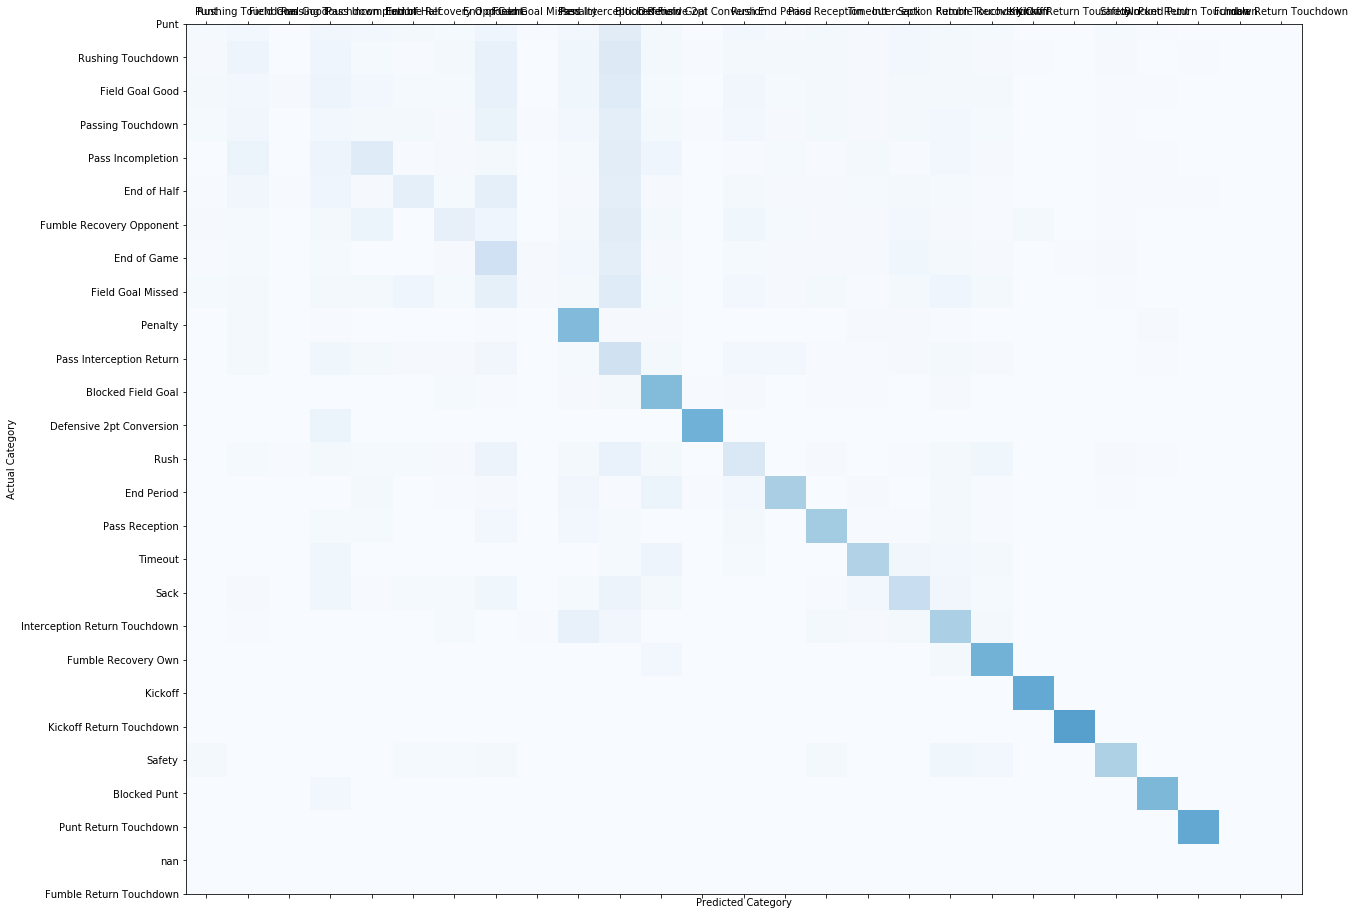

In [394]:
fig, ax = plt.subplots(1,1,figsize=(20,16))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(27), df['result'].unique())
plt.xlabel('Predicted Category')
plt.xticks(range(27), df['result'].unique())
plt.show()

In [369]:
for j in range(len(x_val)):
    
    probs, index = torch.max(softmax(model(x_val[j].unsqueeze(0))), dim=1)

    for p, i in zip(probs, index):
        print('{0} - {1:.4f}'.format(df['result'].unique()[i], p))

/usr/local/Cellar/ipython/7.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


Pass Interception Return - 0.1775
Penalty - 0.2361
Rushing Touchdown - 0.3508
Pass Interception Return - 0.1476
Rushing Touchdown - 0.3739
Rushing Touchdown - 0.1587
Blocked Punt - 0.9833
Pass Interception Return - 0.1650
Fumble Recovery Opponent - 0.1723
Passing Touchdown - 0.3549
Pass Interception Return - 0.1574
Interception Return Touchdown - 0.7186
Penalty - 0.6239
Penalty - 0.5855
Rushing Touchdown - 0.1769
Fumble Recovery Own - 0.9766
End of Half - 0.2055
Rush - 0.3511
Rushing Touchdown - 0.1147
Blocked Punt - 0.9851
Blocked Punt - 0.9855
Pass Reception - 0.8724
Pass Reception - 0.7037
Safety - 0.9977
End of Game - 0.1788
Pass Interception Return - 0.1476
Pass Interception Return - 0.1332
End of Game - 0.1392
Blocked Field Goal - 0.1214
Penalty - 0.4772
Penalty - 0.7285
Pass Interception Return - 0.1249
Pass Interception Return - 0.1536
Pass Interception Return - 0.1286
Passing Touchdown - 0.1971
Pass Interception Return - 0.1476
Blocked Punt - 0.9246
Pass Interception Return - 

Fumble Recovery Opponent - 0.2835
Pass Interception Return - 0.3935
Pass Interception Return - 0.1476
Rush - 0.5798
Blocked Field Goal - 0.7058
Pass Interception Return - 0.1358
Blocked Field Goal - 0.9851
Blocked Field Goal - 0.8384
Blocked Field Goal - 0.6492
Interception Return Touchdown - 0.2095
Pass Interception Return - 0.2281
Pass Reception - 0.8377
Field Goal Missed - 0.1220
Safety - 0.3998
Field Goal Missed - 0.1235
Blocked Field Goal - 0.7789
Pass Interception Return - 0.1581
Blocked Field Goal - 0.8802
Pass Interception Return - 0.6211
Pass Incompletion - 0.4594
Pass Incompletion - 0.3759
Safety - 0.9959
Blocked Field Goal - 0.2800
Blocked Field Goal - 0.4457
Blocked Field Goal - 0.8384
Pass Incompletion - 0.1303
Pass Interception Return - 0.1583
Blocked Field Goal - 0.2382
Blocked Field Goal - 0.8384
Pass Interception Return - 0.1796
Rushing Touchdown - 0.1392
Pass Interception Return - 0.1476
Fumble Recovery Opponent - 0.3180
Rushing Touchdown - 0.2297
Pass Reception - 0.9

Interception Return Touchdown - 0.2678
Pass Interception Return - 0.1476
Blocked Field Goal - 0.1989
End of Game - 0.1435
Passing Touchdown - 0.1866
End of Game - 0.1359
Penalty - 0.1535
Blocked Field Goal - 0.8820
Interception Return Touchdown - 0.2678
Interception Return Touchdown - 0.2678
Pass Interception Return - 0.1477
Blocked Field Goal - 0.9710
Interception Return Touchdown - 0.9980
Safety - 0.9977
Blocked Punt - 0.9331
Pass Interception Return - 0.1425
Blocked Field Goal - 0.1500
Blocked Field Goal - 0.8863
Pass Interception Return - 0.1542
Penalty - 0.8746
Rushing Touchdown - 0.3071
End of Game - 0.5096
Safety - 0.9992
Passing Touchdown - 0.1872
Sack - 0.3144
Pass Interception Return - 0.1067
Pass Interception Return - 0.1485
End of Game - 0.2182
End of Game - 0.9212
Pass Reception - 0.4230
Pass Reception - 0.2032
Pass Reception - 0.1696
Pass Interception Return - 0.1253
Pass Interception Return - 0.1411
Pass Interception Return - 0.1458
Interception Return Touchdown - 0.2678

Kickoff - 0.8450
Punt - 0.1628
End of Game - 0.3555
Rushing Touchdown - 0.2359
End Period - 0.7618
Penalty - 0.2842
Pass Interception Return - 0.4122
Sack - 0.1787
Safety - 0.8940
Sack - 0.2811
Interception Return Touchdown - 0.2678
Interception Return Touchdown - 0.2678
Pass Interception Return - 0.1399
Pass Reception - 0.2950
Pass Interception Return - 0.1067
Pass Interception Return - 0.1460
End of Game - 0.2725
Pass Interception Return - 0.1464
Blocked Field Goal - 0.6650
Pass Interception Return - 0.1245
Sack - 0.1419
End of Game - 0.2725
End of Game - 0.2725
End of Game - 0.1576
Sack - 0.2174
Sack - 0.2333
End of Game - 0.1205
Interception Return Touchdown - 0.2678
Blocked Field Goal - 0.1545
Blocked Field Goal - 0.6923
Passing Touchdown - 0.2268
Pass Interception Return - 0.2516
Pass Interception Return - 0.1477
Pass Interception Return - 0.1673
Penalty - 0.3031
Pass Interception Return - 0.1365
Penalty - 0.5498
Penalty - 0.3509
Blocked Field Goal - 0.5113
Fumble Recovery Oppone

Timeout - 0.2171
Sack - 0.3751
End of Game - 0.2947
Passing Touchdown - 0.3844
Pass Interception Return - 0.1681
Pass Interception Return - 0.1989
Pass Interception Return - 0.1621
Pass Interception Return - 0.1987
Fumble Recovery Own - 0.8931
End of Game - 0.6217
Field Goal Good - 0.2350
Pass Interception Return - 0.1527
Interception Return Touchdown - 0.9734
End of Game - 0.2460
End of Game - 0.2145
Pass Interception Return - 0.1360
Pass Interception Return - 0.1922
Passing Touchdown - 0.1350
Pass Reception - 0.6016
Penalty - 0.2972
Pass Reception - 0.7001
Pass Interception Return - 0.1725
End Period - 0.9006
End Period - 0.9006
End of Game - 0.1682
Fumble Recovery Opponent - 0.3335
End of Game - 0.3947
End of Game - 0.4064
Rushing Touchdown - 0.2125
Fumble Recovery Own - 0.5862
Blocked Punt - 0.9966
Pass Interception Return - 0.2835
Pass Interception Return - 0.1752
Pass Interception Return - 0.9990
End of Game - 0.2460
End of Game - 0.1905
End Period - 0.4474
Passing Touchdown - 0.

End of Game - 0.2724
Sack - 0.1986
Timeout - 0.2171
Timeout - 0.2171
Passing Touchdown - 0.1884
Blocked Field Goal - 0.3218
Sack - 0.3490
End of Game - 0.1936
Blocked Field Goal - 0.4508
End of Game - 0.1813
Pass Interception Return - 0.1476
Timeout - 0.2171
End of Game - 0.2875
Pass Interception Return - 0.1566
Interception Return Touchdown - 0.7023
Sack - 0.2520
Pass Incompletion - 0.2764
Pass Interception Return - 0.1289
Rush - 0.2508
Penalty - 0.5068
Penalty - 0.6970
Pass Interception Return - 0.6518
Pass Interception Return - 0.1481
Pass Interception Return - 0.1667
Interception Return Touchdown - 0.7397
Pass Interception Return - 0.1476
Rushing Touchdown - 0.2162
Timeout - 0.2171
Fumble Recovery Opponent - 0.1669
Blocked Field Goal - 0.1214
Penalty - 0.5736
Rushing Touchdown - 0.5482
Pass Interception Return - 0.1681
Pass Interception Return - 0.1170
Pass Interception Return - 0.1526
Pass Interception Return - 0.1475
Rushing Touchdown - 0.2140
Pass Interception Return - 0.1448
Bl

KeyboardInterrupt: 

## New DataSet to validate on

In [395]:
week2 = pd.read_csv('PBP - 2016 - Week 2.csv')

In [396]:
for index,row in week2.iterrows():
    week2.at[index,'result'] = getDriveResult(row['driveIndex'], row['gameId'], week2)

In [397]:
week2['description'] = week2['description'].str.replace('[^\w\s]','')
week2['description'] = week2['description'].str.replace('[{}]'.format(string.punctuation), '')
week2['result'] = week2['result'].str.replace('[^\w\s]','')

In [414]:
x = week2['description']
y = week2['result']

x = x.values
y = y.values

In [415]:
## ensure that all the data is actually text
new_x_train = []
for i in x:
    new_x_train.append(str(i))
    
x = new_x_train

## ensure that all the data is actually text
new_y_train = []
for i in y:
    new_y_train.append(str(i))
    
y = new_y_train

In [416]:
## convert texts to padded sequences 
x= tokenizer.texts_to_sequences(x)
x = keras.preprocessing.sequence.pad_sequences(x, maxlen = 70)

In [417]:
y_tr_prep = []
for result in y:
    i = 0
    for type in df['result'].unique():
        if(result == type):
            y_tr_prep.append(i)
        i+=1
y = y_tr_prep

In [418]:
x.shape

(13548, 70)

In [419]:
len(y)

13547

In [409]:
x_val = torch.tensor(x, dtype=torch.long)
y_val = torch.tensor(y, dtype=torch.float32)
valid = TensorDataset(x_val, y_val)
valid2 = torch.utils.data.DataLoader(valid, batch_size=1)


In [420]:
total_correct = 0
total_images = 0
preds = np.empty((0,1))
lebs = np.empty((0,1))
confusion_matrix = np.zeros([27,27], int)
with torch.no_grad():
    for data in valid2:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels.long()).sum().item()
        preds = np.append(preds,predicted)
        lebs = np.append(lebs,labels)
        for i, l in enumerate(labels):
            confusion_matrix[int(l.item()), predicted[i].item()] += 1 

print(total_correct)
model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} train plays: {1:.2f}%'.format(total_images, model_accuracy))

939
Model accuracy on 13548 train plays: 6.93%


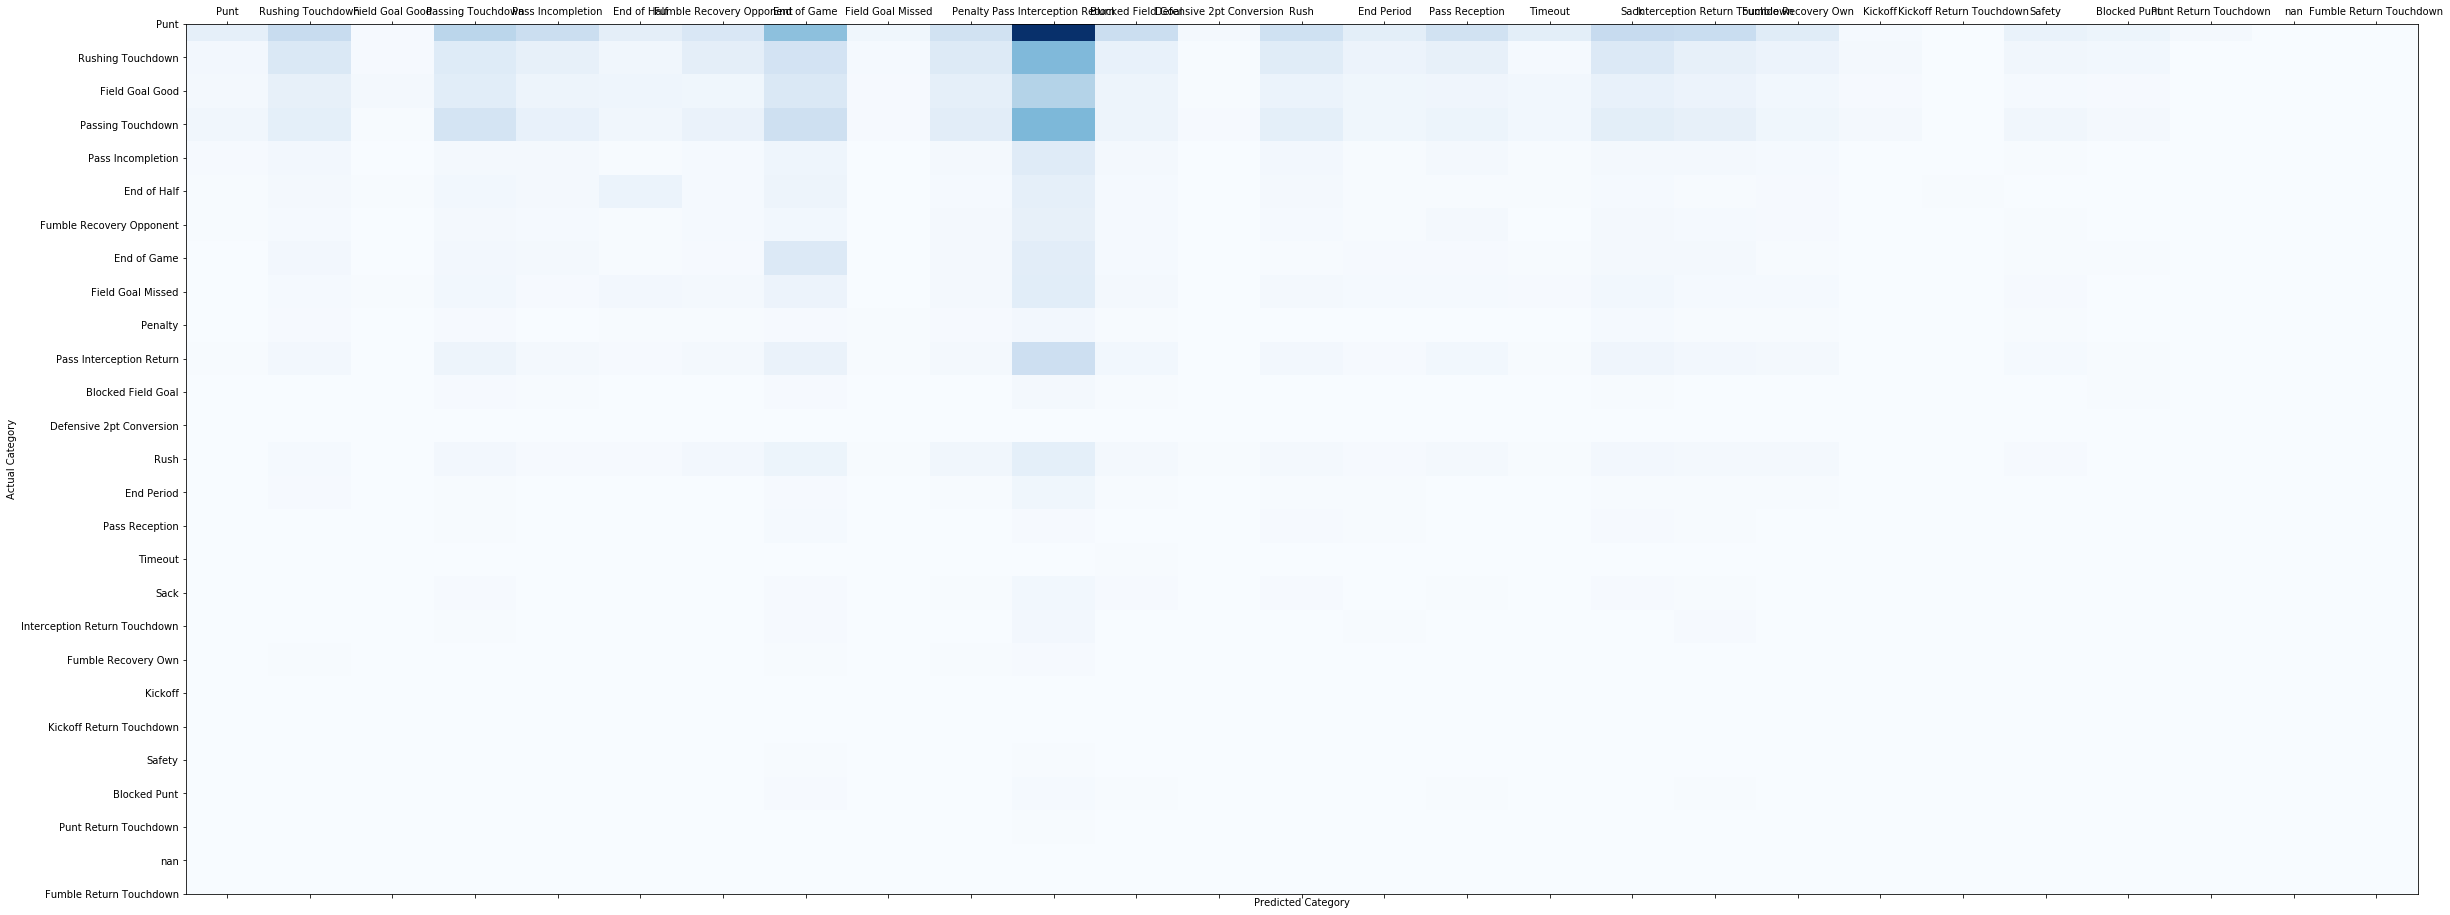

In [423]:
fig, ax = plt.subplots(1,1,figsize=(40,16))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(27), df['result'].unique())
plt.xlabel('Predicted Category')
plt.xticks(range(27), df['result'].unique())
plt.show()

In [422]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    calc = r[i]/np.sum(r)*100
    if np.sum(r) == 0:
        calc = 0
    print('{0:10} - {1:.1f}'.format(df['result'].unique()[i], calc))

Category   - Accuracy
Punt       - 1.9
Rushing Touchdown - 7.1
Field Goal Good - 1.7
Passing Touchdown - 9.5
Pass Incompletion - 4.3
End of Half - 15.8
Fumble Recovery Opponent - 4.9
End of Game - 29.4
Field Goal Missed - 0.7
Penalty    - 8.7
Pass Interception Return - 33.4
Blocked Field Goal - 6.6
Defensive 2pt Conversion - 0.0
Rush       - 4.0
End Period - 6.2
Pass Reception - 4.3
Timeout    - 0.0
Sack       - 9.5
Interception Return Touchdown - 11.3
Fumble Recovery Own - 4.0
Kickoff    - 8.3
Kickoff Return Touchdown - 20.0
Safety     - 5.0
Blocked Punt - 3.7
Punt Return Touchdown - 5.3
       nan - 0.0
Fumble Return Touchdown - 0.0


/usr/local/Cellar/ipython/7.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
